In [36]:
import tensorflow as tf
from keras.datasets import fashion_mnist
import keras as keras
import numpy as np
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras import utils
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import models
from keras import layers

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


from keras.applications.vgg16 import VGG16

In [37]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
y_train = utils.to_categorical(y_train)
y_test =utils.to_categorical(y_test)
x_train=np.reshape(x_train, (-1,28,28,1))
x_test=np.reshape(x_test, (-1,28,28,1))
x_train = Concatenate()([x_train,x_train,x_train])
x_test = Concatenate()([x_test,x_test,x_test])

resized_x_train = tf.image.resize(x_train, (32,32))
resized_x_test = tf.image.resize(x_test, (32,32))


In [38]:
resized_x_train = tf.image.resize(x_train, (32,32))
resized_x_test = tf.image.resize(x_test, (32,32))


In [39]:
train_X = np.asarray([img_to_array(im) for im in resized_x_train])
test_X = np.asarray([img_to_array(im) for im in resized_x_test])

x_train,x_val,y_train,y_val = train_test_split(train_X,
                                                           y_train,
                                                           test_size=0.3,
                                                           random_state=12
                                                           )
train_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

test_generator = ImageDataGenerator(
    rescale=1./255
)
train_generator.fit(x_train)
test_generator.fit(x_val)
train_generator = train_generator.flow(x_train,y_train,batch_size=50)
test_generator = test_generator.flow(x_val,y_val,batch_size=50)
x_test.shape

TensorShape([10000, 28, 28, 3])

In [40]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False



original_dim = (32, 32, 3)
target_size = (150, 150)


model = models.Sequential()
model.add(layers.Input(original_dim))
model.add(layers.Lambda(lambda image: tf.image.resize(image, target_size)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_8 (Lambda)           (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_39 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dense_41 (Dense)            (None, 10)               

In [41]:
checkpointer = ModelCheckpoint(filepath='best_weights.hdf5',verbose=1, save_best_only= True)

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(1e-4),
              metrics=['acc'])

history = model.fit(train_generator,
                    epochs=2,
                    steps_per_epoch=100,
                    validation_data=test_generator,
                    validation_steps=60,
                    shuffle=True,
                    callbacks=[checkpointer])

Epoch 1/2
100/100 [==============================] - ETA: 0s - loss: 0.2409 - acc: 0.4638
Epoch 1: val_loss improved from inf to 0.12877, saving model to best_weights.hdf5


c:\Users\camyr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 645s 6s/step - loss: 0.2409 - acc: 0.4638 - val_loss: 0.1288 - val_acc: 0.7290
Epoch 2/2
100/100 [==============================] - ETA: 0s - loss: 0.1410 - acc: 0.7080
Epoch 2: val_loss improved from 0.12877 to 0.09117, saving model to best_weights.hdf5
100/100 [==============================] - 868s 9s/step - loss: 0.1410 - acc: 0.7080 - val_loss: 0.0912 - val_acc: 0.7933


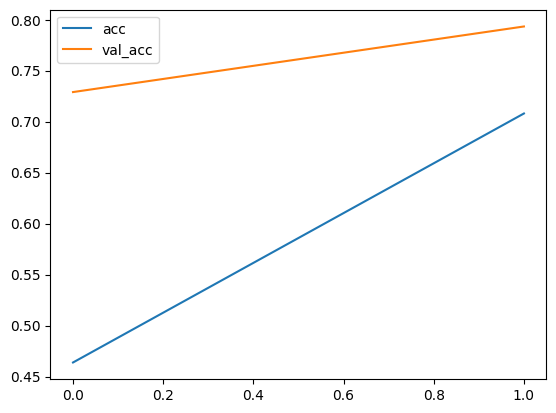

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'],label='acc')
plt.plot(history.history['val_acc'],label='val_acc')
plt.legend()

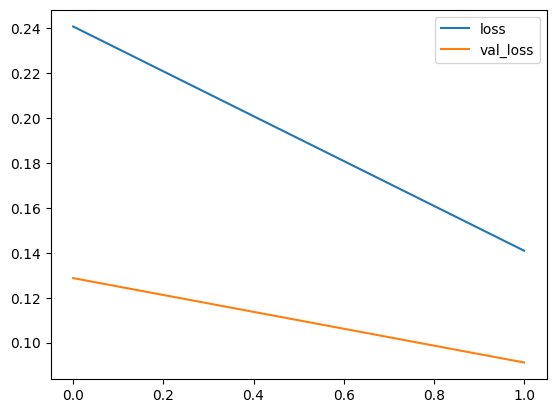

In [43]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

In [45]:
x_test = tf.image.resize(x_test,(150,150))
test_generator = ImageDataGenerator(
    rescale=1./255
)

test_generator.fit(x_test)

test_generator = test_generator.flow(
        x_test,
        y_test,
        batch_size=100)

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

50/50 [==============================] - 205s 4s/step - loss: 0.0920 - acc: 0.7990
test acc: 0.7990000247955322


In [46]:
model = keras.models.load_model('best_weights.hdf5')